<a href="https://colab.research.google.com/github/Qwecie/CarCare-Ai/blob/main/CDU_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium stable-baselines3 matplotlib


Saving to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Adding the environment

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

class CrudeDistillationEnv(gym.Env):
    def __init__(self):
        super(CrudeDistillationEnv, self).__init__()
        self.feed_rate = 100

        # Define action space: [delta_duty, delta_reflux, delta_temp, delta_pressure]
        self.action_space = spaces.Box(
            low=np.array([-0.1, -0.1, -2.0, -0.1], dtype=np.float32),
            high=np.array([0.1, 0.1, 2.0, 0.1], dtype=np.float32)
        )

        # Define observation space
        self.observation_space = spaces.Box(
            low=np.array([1.0, 0.5, 100, 0.5, 0.0, 0.0], dtype=np.float32),
            high=np.array([6.0, 4.0, 200, 2.0, 100.0, 100.0], dtype=np.float32)
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.reboiler_duty = 3.0
        self.reflux_ratio = 1.5
        self.feed_temp = 120.0
        self.pressure = 1.0

        top_yield = (0.3 + 0.1 * (self.reflux_ratio - 1.0)) * self.feed_rate
        bottom_yield = self.feed_rate - top_yield

        obs = np.array([
            self.reboiler_duty,
            self.reflux_ratio,
            self.feed_temp,
            self.pressure,
            top_yield,
            bottom_yield
        ], dtype=np.float32)

        return obs, {}

    def step(self, action):
        self.reboiler_duty += action[0]
        self.reflux_ratio += action[1]
        self.feed_temp += action[2]
        self.pressure += action[3]

        # Clamp values to valid operational limits
        self.reboiler_duty = float(np.clip(self.reboiler_duty, 1.0, 6.0))
        self.reflux_ratio = float(np.clip(self.reflux_ratio, 0.5, 4.0))
        self.feed_temp = float(np.clip(self.feed_temp, 100, 200))
        self.pressure = float(np.clip(self.pressure, 0.5, 2.0))

        # Simplified yield model
        top_yield = (0.3 + 0.1 * (self.reflux_ratio - 1.0)) * self.feed_rate
        bottom_yield = self.feed_rate - top_yield

        # Reward calculation
        spec_penalty = -100 * (top_yield / self.feed_rate - 0.4) ** 2
        energy_cost = self.reboiler_duty * 10
        reward = spec_penalty - energy_cost

        obs = np.array([
            self.reboiler_duty,
            self.reflux_ratio,
            self.feed_temp,
            self.pressure,
            top_yield,
            bottom_yield
        ], dtype=np.float32)

        terminated = False
        truncated = False
        info = {}

        return obs, reward, terminated, truncated, info



Texting the environment

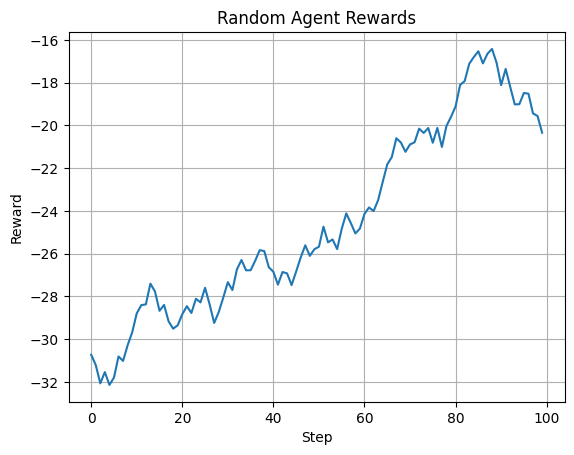

In [ ]:
env = CrudeDistillationEnv()
rewards = []
obs, _ = env.reset()  # ✅ reset returns (obs, info)

for _ in range(100):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)  # ✅ step returns 5 values
    rewards.append(reward)

plt.plot(rewards)
plt.title("Random Agent Rewards")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()



In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Optional: check if your env follows Gym's rules
check_env(env)

# Create a new PPO agent
model = PPO("MlpPolicy", env, learning_rate=0.0001, verbose=1)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Train the agent

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=100_000,
    save_path="/content/drive/MyDrive/ppo_checkpoints/",
    name_prefix="ppo_crude_distillation"
)


model.learn(total_timesteps=1_500_000, callback=checkpoint_callback)




Streaming output truncated to the last 5000 lines.
|    std                  | 0.519       |
|    value_loss           | 4.24e-05    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 660         |
|    iterations           | 471         |
|    time_elapsed         | 1460        |
|    total_timesteps      | 964608      |
| train/                  |             |
|    approx_kl            | 0.013582285 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3          |
|    explained_variance   | 6.06e-05    |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00865    |
|    n_updates            | 10080       |
|    policy_gradient_loss | 0.00511     |
|    std                  | 0.519       |
|    value_loss           | 3.86e-05    |
-----------------------------------------
-------------------------

Evaluating the trained agent

Total reward over episode: -1190.76


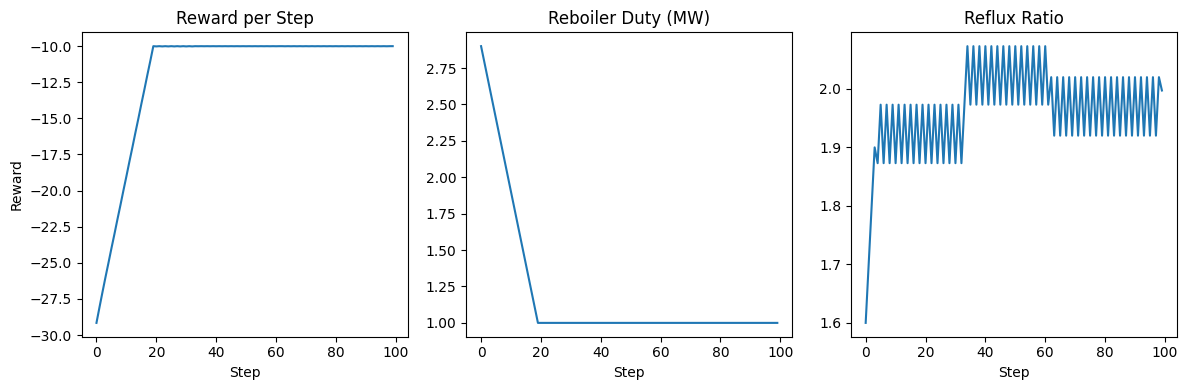

In [ ]:
obs, _ = env.reset()
ppo_rewards = []
reboiler_duties = []
reflux_ratios = []
total_reward = 0

for _ in range(100):
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    ppo_rewards.append(reward)
    reboiler_duties.append(obs[0])
    reflux_ratios.append(obs[1])

print(f"Total reward over episode: {total_reward:.2f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(ppo_rewards)
plt.title("Reward per Step")
plt.xlabel("Step")
plt.ylabel("Reward")

plt.subplot(1, 3, 2)
plt.plot(reboiler_duties)
plt.title("Reboiler Duty (MW)")
plt.xlabel("Step")

plt.subplot(1, 3, 3)
plt.plot(reflux_ratios)
plt.title("Reflux Ratio")
plt.xlabel("Step")

plt.tight_layout()
plt.show()
